In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 29 23:25:36 2019

@author: Kendrick, Yusuf

"""

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

import numpy as np
from neural_net import GNN
import utils
import load_entrez
import load_assoc
import copy
import importlib
importlib.reload(load_assoc)

## Given a graph and training mask, obtain 5 folds for train/val splits
def make_cross_val_sets(data, n=5):

    idx_0 = np.where(data.y[data.train_mask]==0)[0]
    np.random.seed(40)
    np.random.shuffle(idx_0)
    intervals_0 = np.linspace(0,len(idx_0),n+1).astype(int)

    idx_1 = np.where(data.y[data.train_mask]==1)[0]
    np.random.seed(50)
    np.random.shuffle(idx_1)
    intervals_1 = np.linspace(0,len(idx_1),n+1).astype(int)

    masks = []
    prev = 0
    for i in range(1,n+1):
        s = np.array([False]*len(data.y)) 
        s[idx_0[intervals_0[i-1]:intervals_0[i]]] = True
        s[idx_1[intervals_1[i-1]:intervals_1[i]]] = True
        masks.append(s)

    return masks

def get_acc(model, loader, is_val):
    correct = 0
    total = 0
    if is_val:
        model.eval()
    for d in loader:
        with torch.no_grad():
            if is_val:
                pred = model(d).max(dim=1)[1][d.val_mask]
                label = d.y[d.val_mask]
            else:
                pred = model(d).max(dim=1)[1][d.test_mask]
                label = d.y[d.test_mask]
            print(np.unique(pred,return_counts=True)[1])
        correct += pred.eq(label).sum().item()

        if is_val:
            total += torch.sum(d.val_mask).item()
        else:
            total += torch.sum(d.test_mask).item()
    return correct/total

def get_weight(x_):
    a,b = np.unique(x_, return_counts=True)[1]
    return torch.tensor([(1-a/(a+b)), (1-b/(a+b))])

# Identifies k nodes form each class within a given mask and removes the rest
def sample_from_mask(mask, data, k):
    counts = {}
    counts[0] = 0
    counts[1] = 0
    for i,val in enumerate(mask):
        if val == True:
            if data.y[i] == 0:
                counts[0] += 1
            else:
                counts[1] += 1
            if counts[data.y[i].item()] > k:
                mask[i] = False
    return mask

def train(loader, weight, epochs = 50):
    model = GNN(3, 32, 2, 'GCNConv')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = F.nll_loss
    val_acc = [] 
    model_save = copy.deepcopy(model)

    for epoch in range(epochs):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask], weight=weight)
            loss.backward()
            optimizer.step()
            print('loss on epoch', epoch, 'is', loss.item())
            
            if epoch % 5 == 0:
                val_acc.append(get_acc(model, loader, is_val = True))
                print('Validation:', val_acc[-1])
                if(val_acc[-1]==np.max(val_acc)):
                    model_save = copy.deepcopy(model)
                    best_acc = val_acc[-1]

    return val_acc, model_save, best_acc

def trainer(num_folds = 5):
    # X_file = 'https://github.com/yhr91/CS224W_project/blob/master/Data/ForAnalysis/X/TCGA_GTEX_GeneExpression.csv?raw=true'
    # y_file = 'https://github.com/yhr91/CS224W_project/raw/master/Data/ForAnalysis/Y/NCG_cancergenes_list.txt'
    # edgelist_file = 'https://github.com/yhr91/CS224W_project/blob/master/Data/PP-Decagon_ppi.csv?raw=true'
    y_file = '../dataset_collection/DG-AssocMiner_miner-disease-gene.tsv'
    edgelist_file = '../dataset_collection/PP-Decagon_ppi.csv'
    X = load_assoc.get_X(edgelist_file)
    y = load_assoc.get_y(y_file, edgelist_file)
    edges = load_assoc.get_edges(edgelist_file)

    X = torch.tensor(X.values, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    edges = torch.tensor(edges.values, dtype=torch.long)

    # Set up train and test sets:
    data = utils.load_pyg(X, edges, y)
    masks = make_cross_val_sets(data, num_folds)

    # 5-fold cross validation
    val_accs, models, accs = [], [], []
    for val_idx in range(num_folds):
        print('Fold number:', val_idx)
        train_idx = np.delete(np.arange(num_folds),val_idx)
        train_mask = [False] * len(data.y)
        for i in range(len(train_idx)):
            train_mask = np.logical_or(train_mask,masks[i])
        
        ## For the validation mask, use the validation fold but 
        ## pick equal nodes from each class
        val_mask = masks[val_idx]
        val_mask = sample_from_mask(val_mask, data, 100)

        # Call training function
        data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
        data.val_mask = torch.tensor(val_mask, dtype=torch.bool)
        loader = DataLoader([data], batch_size=32, shuffle=True)
        weight = get_weight(data.y[train_mask])
        
        v, m, acc = train(loader, weight)
        val_accs.append(v)
        models.append(m)
        accs.append(acc)

    best_model = models[np.argmax(accs)]
    print('Best model accuracy:')
    acc = get_acc(m, loader, is_val = False)
    print(acc)

    return val_accs

In [25]:
trainer()

IndexError: single positional indexer is out-of-bounds

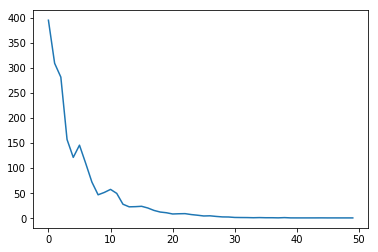

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses[:50])
plt.show()